In [69]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import stephane.display.graphes as graphes
import stephane.elasticity.processing as proc
import fluids2d.backlight as bl
import pims
import fluids2d.piv as piv
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import stephane.tools.Smath as Smath
import stephane.display.graphes as graphes

import os
import scipy.interpolate as interp

In [60]:
cinefile = '/media/stephane/OS/Documents and Settings/Stephane/Documents/Data_buffer/20181010/PIV3dscan_nikon50mm_f1kHz_A800mV_offsetm2800mV_4pumpsOn.cine'
fps = 40000
f = 1000
date = '20181010'
data_folder = '/media/stephane/DATA/Experimental_data/Turbulence3d/'+date+'/'
save_folder = data_folder+ 'test3d3c/'
print(data_folder)
print(save_folder)
#os.makedirs(save_folder)

/media/stephane/DATA/Experimental_data/Turbulence3d/20181010/
/media/stephane/DATA/Experimental_data/Turbulence3d/20181010/test3d3c/


In [61]:
glob.glob(data_folder+'test3d3c/*')

[]

In [16]:
c = pims.open(cinefile)
print(c.len())
Nc = int(fps/f)

120001


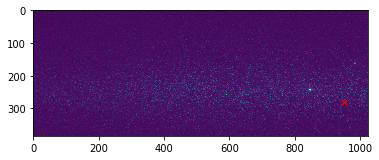

In [5]:
plt.imshow(c.get_frame(0))
plt.plot([950],[280],'rx')

In [131]:
a=np.load('/media/stephane/DATA/Experimental_data/Turbulence3d/20181010/test3d3c/window32x20/_flowfield.npy')

In [132]:
print(a.shape)

(998, 23, 1, 2)


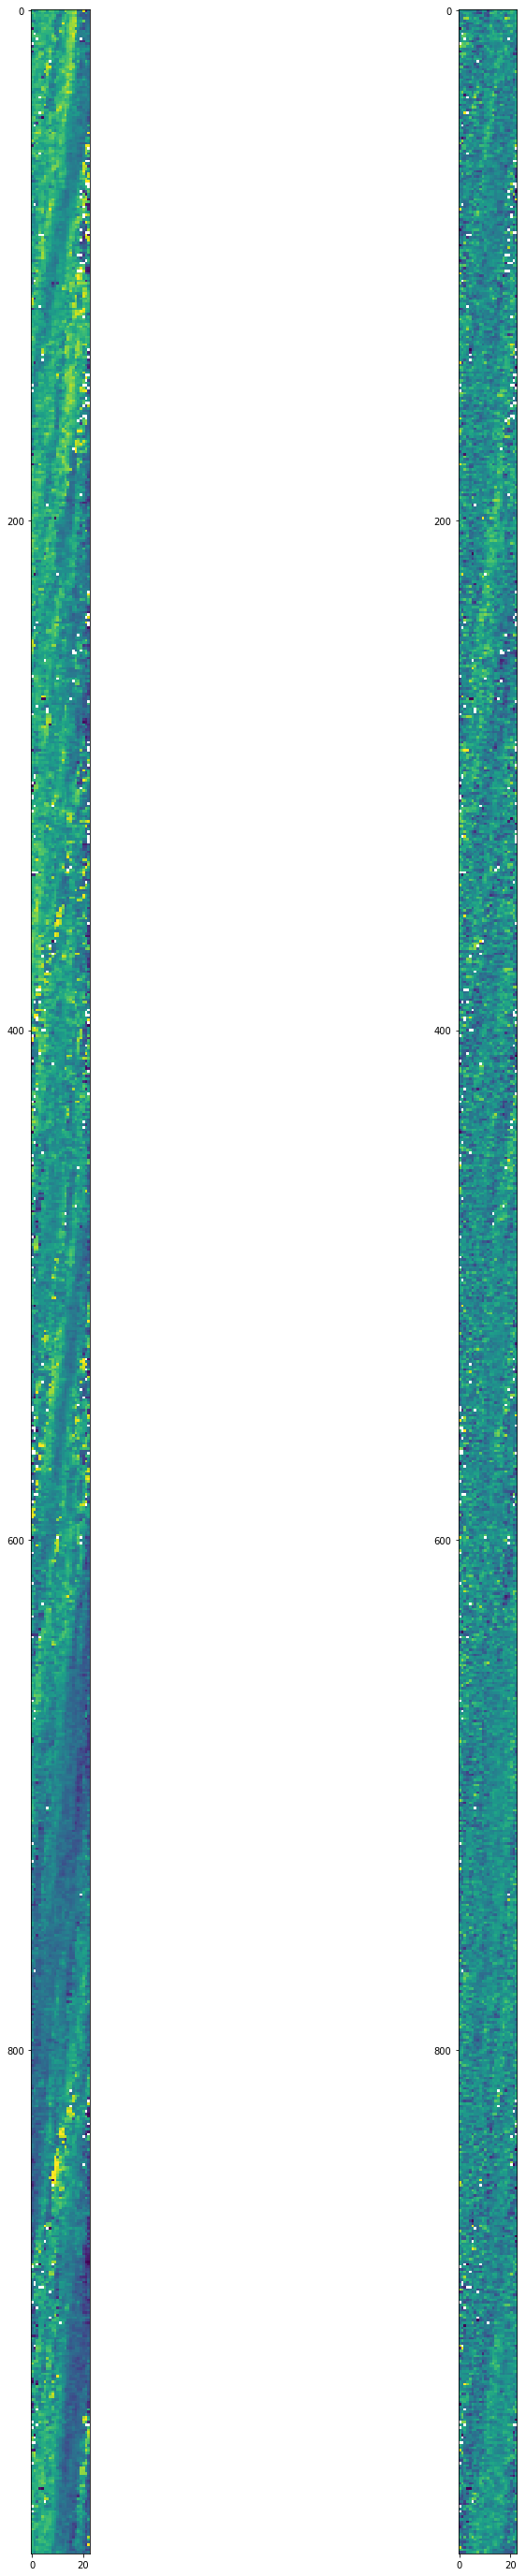

In [133]:
fig,axs=plt.subplots(1,2,figsize=(15,50))
plt.subplot(1,2,1)
plt.imshow(a[...,0,1],vmin=0,vmax=3)

plt.subplot(1,2,2)
plt.imshow(a[...,0,0],vmin=-0.5,vmax=0.5)

#plt.colorbar()

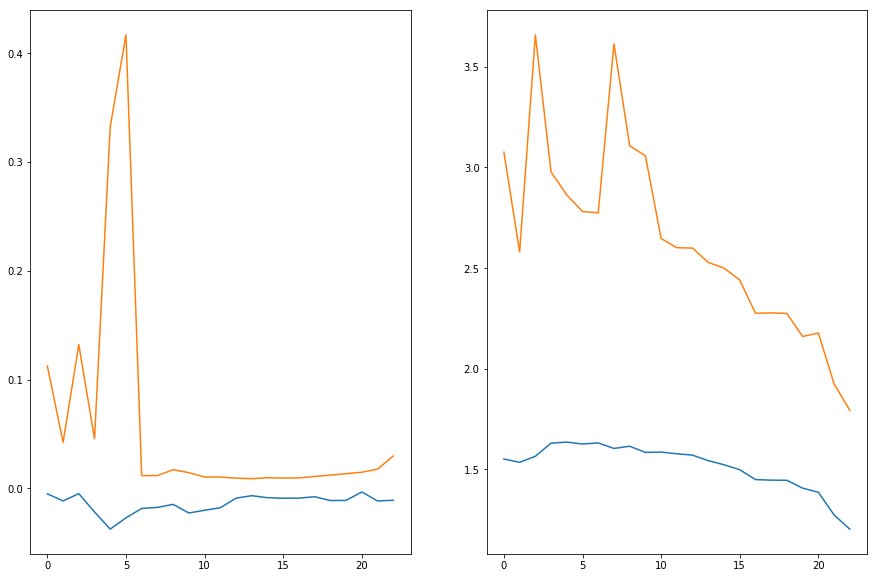

In [136]:
fig,axs=plt.subplots(1,2,figsize=(15,10))

mean_flow = np.nanmean(a[...,0,:],axis=0)
mean_rms = np.nanmean((a[...,0,:])**2,axis=0)

plt.subplot(1,2,1)
plt.plot(mean_flow[:,0])
plt.plot(mean_rms[:,0])

plt.subplot(1,2,2)
plt.plot(mean_flow[:,1])
plt.plot(mean_rms[:,1])
#plt.colorbar()

In [25]:
im0 = c.get_frame(0)
(Nx,Ny)=im0.shape
Nex = 10
Vol = np.zeros((Nex,Nx,Ny,Nc))
N = Nex*Nc
for i in range(N):
    Vol[i//Nc,...,i%Nc]=c.get_frame(i)
print(Vol.shape)


(10, 384, 1024, 40)


In [68]:
type(c[0])
c[0]=Vol[0,:,600,0:20]

TypeError: 'Cine' object does not support item assignment

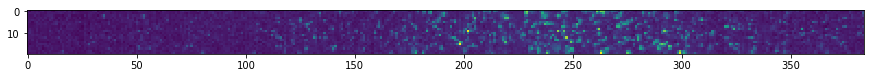

In [64]:
#plt.figure()
#plt.imshow(Vol[0,...,0])

fig,axs=plt.subplots(1,1,figsize=(15,8))
for i in range(10):
    plt.imshow(np.transpose(Vol[i,:,600,0:20]))
    plt.savefig(save_folder+'im'+str(i)+'.png', dpi=300)

In [293]:
parent_folder = '/media/stephane/' 
date = '20181018'
cine_name = 'OS/Documents and Settings/Stephane/Documents/Data_buffer/20181010/PIV3dscan_nikon50mm_f1kHz_A800mV_offsetm2800mV_rotator'
data_folder = 'DATA/Experimental_data/Turbulence3d/'+date+'/raw'
save_folder = data_folder+ '/fluctuations/'

dx =  0.35E-03#7.3469357156E-05
dt_orig = 1./31000

crop_lims=None
pre_constructed_masker = None
t0 = 21
a_frames = np.arange(t0,93000+t0,1)
frame_diff = 31

window_size = 32
overlap = 16

processing = piv.PIVDataProcessing(parent_folder,cine_name,name_for_save=data_folder,dx=dx,dt_orig=dt_orig,frame_diff=frame_diff,crop_lims=crop_lims,maskers=None,window_size=window_size,overlap=overlap,search_area_size=32)
processing.associate_flowfield()
ff = processing.data.ff

dx : 
0.00035
dt_ab: 
0.001


In [294]:
 #convert 2d to 3d data
(Nt,Nx,Ny,Nc) = ff.shape
ff = np.reshape(ff,(int(Nt/frame_diff),frame_diff,Nx,Ny,Nc))

#keep only one way volume scan
ff = ff[:,2:18,...]

ff[...,1] = -ff[...,1] #reverse sign of horizontal component
print(ff.shape)

(3000, 16, 31, 63, 2)


In [295]:
#compute mean_flow
mean_flow = np.nanmean(ff,axis=0)
mean_flow_speed = np.linalg.norm(mean_flow,axis=2)
mean_speed = np.nanmean( np.sqrt(ff[...,0]**2 + ff[...,1]**2 ), axis=0)
fluc = ff - mean_flow    
u_rms = np.sqrt(np.nanmean( fluc[...,0]**2+fluc[...,1]**2 ,axis=0) )

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [296]:
(Nz,Nx,Ny,Nc) = mean_flow.shape
print(mean_flow.shape)

(16, 31, 63, 2)


In [333]:
#generate axis
#(Nz,Nx,Ny,Nc) = mean_flow.shape
#mean_flow = np.transpose(mean_flow,(1,2,0,3))

dz = 45/15.5
x = np.arange(-(Nx-1)/2,(Nx-1)/2+1)*processing.dx*1E3*overlap+5
y = np.arange(-(Ny-1)/2,(Ny-1)/2+1)*processing.dx*1E3*overlap-120
z = np.arange(-Nz/2,Nz/2)*dz-2

#invariance by rotation in the plane (x,z)

[X,Z,Y] = np.meshgrid(x,z,y)

In [118]:
print(mean_flow.shape)
print(X[:,:,:].shape)

(16, 31, 63, 2)
(16, 31, 63)


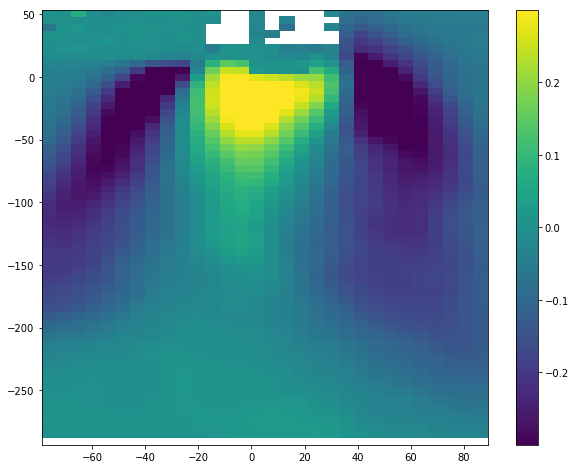

In [334]:
fig,axs=plt.subplots(1,1,figsize=(10,8))
plt.pcolormesh(X[0,...],Y[0,...],mean_flow[8,...,0],vmin=-0.3,vmax=0.3)
plt.colorbar()

(31, 63)


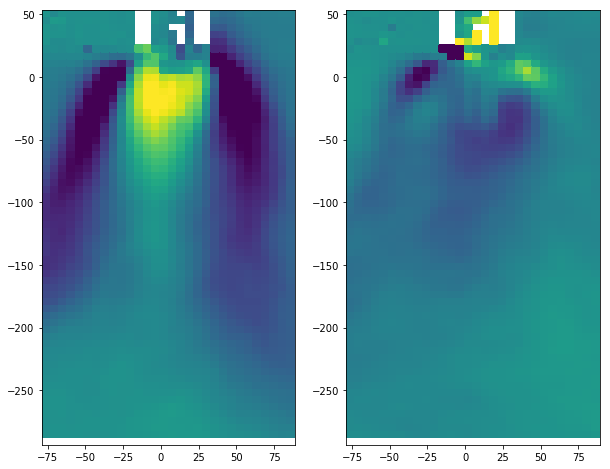

In [335]:
fig,axs=plt.subplots(1,2,figsize=(10,8))
print(mean_flow[10,...,0].shape)
axs[0].pcolormesh(X[0,...],Y[0,...],mean_flow[6,...,0],vmin=-0.3,vmax=0.3)
#plt.colorbar()

axs[1].pcolormesh(X[0,...],Y[0,...],mean_flow[6,...,1],vmin=-0.3,vmax=0.3)

In [338]:
[R,Theta] = Smath.cart2pol(X,Z)
Ur = 2*mean_flow[...,1]*np.cos(Theta)  #coefficient to be compensated by the circle fraction avalaible, so the coeff is r dependent
Utheta = -2*mean_flow[...,1]*np.sin(Theta) #average along Theta still required

fur = interp.RegularGridInterpolator((z,x,y),Ur,method='linear',bounds_error=False,fill_value=np.nan)
fut = interp.RegularGridInterpolator((z,x,y),Utheta,method='linear',bounds_error=False,fill_value=np.nan)
fuz = interp.RegularGridInterpolator((z,x,y),mean_flow[...,0],method='linear',bounds_error=False,fill_value=np.nan)

#futheta = interp.RegularGridInterpolator(Utheta, values, method='linear', bounds_error=True, fill_value=nan)[source]


In [248]:
print(Ur.shape)

(16, 31, 63)


In [242]:
helicity = fur((R[:,:,40]*np.cos(Theta[:,:,]),x[5],y[40]))

array([-0.073379  , -0.07342986, -0.06604033, -0.06482857, -0.06580828,
       -0.06344544, -0.05669815, -0.04911837, -0.03393364, -0.02424669,
       -0.01768416, -0.01310526, -0.00867227, -0.00059881,  0.00032977,
        0.00036066])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/usr/lib/python3/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


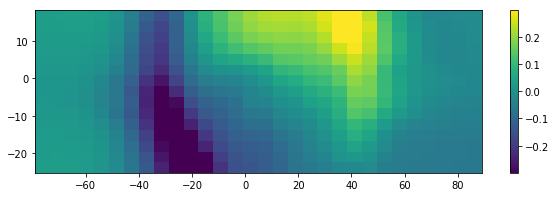

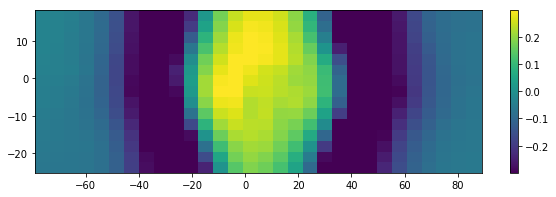

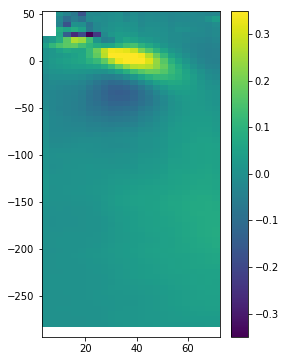

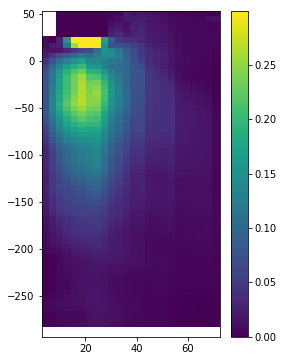

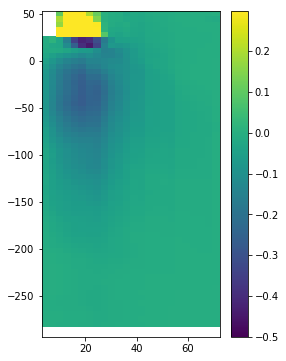

In [340]:
k =52

fig,axs=plt.subplots(1,1,figsize=(10,3))
plt.pcolormesh(X[...,0],Z[...,0],mean_flow[...,k,1],vmin=-0.3,vmax=0.3)
plt.colorbar()

fig,axs=plt.subplots(1,1,figsize=(10,3))
plt.pcolormesh(X[...,0],Z[...,0],mean_flow[...,k,0],vmin=-0.3,vmax=0.3)
plt.colorbar()



#fig,axs=plt.subplots(1,1,figsize=(10,3))
#plt.pcolormesh(X[...,0],Z[...,0],Ur[...,k],vmin=-0.3,vmax=0.3)
dtheta = 2*np.pi/50
theta = np.arange(np.pi/2,2*np.pi+np.pi/2,dtheta)
dr = dz
R0 = np.arange(dz,dz*(Nx-5),dz)
Nr = len(R0)

#plt.plot(np.min(R0)*np.cos(theta),np.min(R0)*np.sin(theta),'r')
#plt.plot(np.max(R0)*np.cos(theta),np.max(R0)*np.sin(theta),'r')

UR = np.zeros((Ny,Nr))
UT = np.zeros((Ny,Nr))
UZ = np.zeros((Ny,Nr))

for i in range(len(y)):
    for j,r0 in enumerate(R0):
        UR[i,j] = np.nanmean(fur((r0*np.cos(theta),r0*np.sin(theta),y[i])))
        UT[i,j] = np.nanmean(fut((r0*np.cos(theta),r0*np.sin(theta),y[i])))
        UZ[i,j] = np.nanmean(fut((r0*np.cos(theta),r0*np.sin(theta),y[i])))
    

fig,axs=plt.subplots(1,1,figsize=(4,6))
plt.pcolormesh(Rf,Yf,UR,vmin=-0.35,vmax=0.35)
plt.colorbar()


fig,axs=plt.subplots(1,1,figsize=(4,6))
plt.pcolormesh(Rf,Yf,-UT,vmin=0.,vmax=0.3)
plt.colorbar()

fig,axs=plt.subplots(1,1,figsize=(4,6))
plt.pcolormesh(Rf,Yf,UZ,vmin=-0.5,vmax=0.3)
plt.colorbar()

y
#fig,axs=plt.subplots(1,1,figsize=(10,3))
#plt.pcolormesh(X[...,0],Z[...,0],Utheta[...,k],vmin=-0.3,vmax=0.3)
#plt.colorbar()



#fig,axs=plt.subplots(1,1,figsize=(5,8))
#plt.pcolormesh(X[0,...],Y[0,...],mean_flow[6,...,1],vmin=-0.3,vmax=0.3)
#plt.colorbar()

In [192]:
#definition of mask
x0 = 175
y0 = 130
width = 120
height = 50

ValueError: cannot reshape array of size 31248 into shape (1,63)

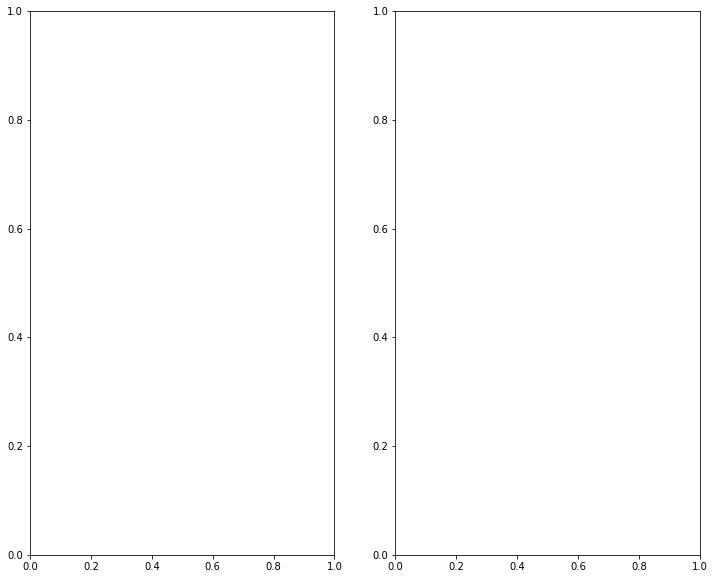

In [121]:
fig,axs=plt.subplots(1,2,figsize=(12,10)); axs=axs.flatten()
cax=[]
c=[]
j = 10
#for i in range(2):
#    divider = make_axes_locatable(axs[i])
#    cax.append(divider.append_axes('right', size='10%', pad=0.1))
    
for (i,data) in zip(range(2),[mean_speed[j,:,:],u_rms[j,:,:]]):
    #axs[i].clear()
    cb=axs[i].pcolormesh(X,Y,data,vmin=0,vmax=0.4)
#            cb=axs[i].pcolormesh(X,Y,ff[0,j,:,:,1],vmin=0,vmax=0.3)
#    fig.colorbar(cb)
#    c.append(fig.colorbar(cb, cax=cax[i], orientation='vertical'))

    axs[0].set_title(r'$y = '+str(int(z[j]))+' mm')
        #axs[1].set_title(r'$\bar u_{rms}$')

    axs[0].set_xlabel('$z$ (mm)')
    axs[i].set_xlabel('$x$ (mm)')
    #c[0].set_label(r'$\bar u$ (m/s)')
    #c[0].set_label(r'$\bar u_{rms}$ (m/s)')
    
    p=patches.Rectangle((x0,y0),width,height,facecolor='w',edgecolor='r')
    axs[i].add_patch(p)